In [1]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import matplotlib.ticker as ticker
import pims
import fnmatch
from skimage import io
import os.path, time

In [97]:
expdir='Y:\\user\\tdanko\\Imaging\\1_ECM\\Live Culture\\Cytation_biospa\\20190311_TNR550_Bic\\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\\190315_125329_Plate 1\\'

In [98]:
results={"filename":[],
         "exp name":[],
        "condition":[],
        "namestem before channel":[],
         "namestem after channel":[],
        "timepoint":[],
        "analyse":[]}

path = os.path.dirname(expdir)  
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if ("montage" in str(filelist[i]))==False:
        
        if filelist[i].endswith(".tif"): 
            results["filename"].append(filelist[i])
            results["analyse"].append(False)
            results["exp name"].append(filelist[i][:-12].split('\\')[-2])
            results["namestem before channel"].append('\\'.join(filelist[i].split('\\')[:-1])+'\\'+'_'.join(filelist[i].split('\\')[-1].split('_')[:-4]))
            results["namestem after channel"].append('_'.join(filelist[i].split('\\')[-1].split('_')[-3:-1]))
            results["timepoint"].append(filelist[i][-7:-4])
            if len(fnmatch.filter([filelist[i]],r'*A[0-9]_*'))>0:
                results["condition"].append("Unblocked")
            elif len(fnmatch.filter([filelist[i]],r'*B[0-9]_*'))>0:
                results["condition"].append("Blocked")
            elif len(fnmatch.filter([filelist[i]],r'*C[0-9]_*'))>0:
                results["condition"].append("Blocked + Bic")
            
            elif len(fnmatch.filter([filelist[i]],r'*D1_*'))>0:
                results["condition"].append("Unblocked")
            elif len(fnmatch.filter([filelist[i]],r'*D2_*'))>0:
                results["condition"].append("Unblocked")
            elif len(fnmatch.filter([filelist[i]],r'*D3_*'))>0:
                results["condition"].append("Unblocked")
            
            elif len(fnmatch.filter([filelist[i]],r'*D4_*'))>0:
                results["condition"].append("Unblocked")
            elif len(fnmatch.filter([filelist[i]],r'*D5_*'))>0:
                results["condition"].append("Blocked")
            elif len(fnmatch.filter([filelist[i]],r'*D6_*'))>0:
                results["condition"].append("Blocked")
            else:
                results["condition"].append('Unspecified')

In [99]:
df=pd.DataFrame(results)

In [100]:
df["condition"].unique()

array(['Unblocked', 'Blocked', 'Blocked + Bic'], dtype=object)

In [101]:
df["timepoint"].max()

'024'

## Throw out images with no cells

In [102]:
no_image_fields=int(len(df)/2/int(df["timepoint"].max())) #divide by no channels and timepoints

    

In [103]:
no_image_fields

384

In [79]:
toanalyse={"namestem":images_list,"analyse":[]}
for i in range(0,len(images_list)):
    toanalyse["analyse"].append(False)

NameError: name 'images_list' is not defined

In [78]:
import ipywidgets as widgets
from ipywidgets import interact



#load first image

ecm_image_name=df["filename"][indexes[0]]
ecm_image = io.imread(ecm_image_name)


def f(Threshold,Image_no):
    
    ii=Image_no
    ecm_image_name=df["filename"][indexes[ii]]
    ecm_image = io.imread(ecm_image_name)

    if Threshold=="Keep":
        df["analyse"][indexes[ii]]=True
    
    fig=plt.figure(figsize=(10,10))
    plt.imshow(ecm_image,cmap='inferno')
    plt.title(ecm_image_name)
    

#widgets
Threshold=widgets.Dropdown(options=["Keep","Toss"])
Image_no=widgets.IntText(min=0,max=len(images_list),value=0)

w=interact(f,Threshold=Threshold,
           Image_no=Image_no)

NameError: name 'indexes' is not defined

In [104]:
indexes=df.loc[df["filename"].str.contains("Phase Contrast_001")].index
timepoints=df["timepoint"].unique()

intensities={"namestem":[],
            "condition":[],
            "intensities vector":[],
            "intensities vector bgsub":[]}
counter=0
for i in indexes:
    counter+=1
    print(str(counter)+' out of ' +str(len(indexes)))
    name=df["filename"][i]
    print(name)
    namestem='\\'.join(name.split('\\')[:-1])+'\\'+'_'.join(name.split('\\')[-1].split('_')[:-4])+'_2_'+name.split('_')[-3]+'_RFP_'
    print(namestem)
    intensities["namestem"].append(namestem)
    intensities["condition"].append(df["condition"][i])
    intensities_vect=[]
    intensities_vect_bgsubtracted=[]
    for time in timepoints:
        print(time)
        fullname=namestem+time+'.tif'
        #read image
        ecm_image = io.imread(fullname)
        intensities_vect.append(ecm_image.mean())
        #bg
        bg=np.mean(ndi.median_filter(ecm_image,size=5))+0*np.std(ndi.median_filter(ecm_image,size=5))
        ecm_bgreduced=np.subtract(ecm_image,bg)
        ecm_bgreduced[ecm_bgreduced<0]=0
        intensities_vect_bgsubtracted.append(ecm_bgreduced.mean())
    intensities["intensities vector"].append(intensities_vect)
    intensities["intensities vector bgsub"].append(intensities_vect_bgsubtracted)

1 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\A1_02_1_10_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\A1_02_2_10_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
2 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\A1_02_1_11_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\A1_02_2_11_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
3 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytatio

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
19 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\A2_02_1_12_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\A2_02_2_12_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
20 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\A2_02_1_13_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\A2_02_2_13_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016


002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
37 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\A3_02_1_14_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\A3_02_2_14_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
38 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\A3_02_1_15_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\A3_02_2_15_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016


002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
55 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\A4_02_1_16_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\A4_02_2_16_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
56 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\A4_02_1_1_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\A4_02_2_1_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
01

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
73 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\A5_02_1_2_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\A5_02_2_2_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
74 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\A5_02_1_3_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\A5_02_2_3_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017


002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
91 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\A6_02_1_4_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\A6_02_2_4_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
92 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\A6_02_1_5_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\A6_02_2_5_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017


002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
109 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\B1_02_1_6_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\B1_02_2_6_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
110 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\B1_02_1_7_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\B1_02_2_7_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
01

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
127 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\B2_02_1_8_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\B2_02_2_8_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
128 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\B2_02_1_9_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\B2_02_2_9_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
01

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
145 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\B4_02_1_10_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\B4_02_2_10_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
146 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\B4_02_1_11_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\B4_02_2_11_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
01

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
163 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\B5_02_1_12_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\B5_02_2_12_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
164 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\B5_02_1_13_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\B5_02_2_13_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
01

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
181 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\B6_02_1_14_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\B6_02_2_14_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
182 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\B6_02_1_15_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\B6_02_2_15_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
01

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
199 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\C1_02_1_16_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\C1_02_2_16_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
200 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\C1_02_1_1_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\C1_02_2_1_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016


002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
217 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\C2_02_1_2_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\C2_02_2_2_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
218 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\C2_02_1_3_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\C2_02_2_3_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
01

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
235 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\C3_02_1_4_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\C3_02_2_4_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
236 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\C3_02_1_5_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\C3_02_2_5_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
01

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
253 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\C4_02_1_6_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\C4_02_2_6_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
254 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\C4_02_1_7_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\C4_02_2_7_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
01

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
271 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\C5_02_1_8_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\C5_02_2_8_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
272 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\C5_02_1_9_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\C5_02_2_9_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
01

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
289 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\D1_02_1_10_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\D1_02_2_10_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
290 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\D1_02_1_11_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\D1_02_2_11_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
01

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
307 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\D2_02_1_12_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\D2_02_2_12_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
308 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\D2_02_1_13_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\D2_02_2_13_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
01

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
325 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\D3_02_1_14_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\D3_02_2_14_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
326 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\D3_02_1_15_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\D3_02_2_15_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
01

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
343 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\D4_02_1_16_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\D4_02_2_16_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
344 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\D4_02_1_1_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\D4_02_2_1_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016


002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
361 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\D5_02_1_2_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\D5_02_2_2_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
362 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\D5_02_1_3_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\D5_02_2_3_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
01

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
379 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\D6_02_1_4_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\D6_02_2_4_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
380 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\D6_02_1_5_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190315_125329_20190306_Tal_TNR550_15-Mar-2019 12-49-51\190315_125329_Plate 1\D6_02_2_5_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
01

In [106]:
for key in intensities.keys():
    print(key)
    print(len(intensities[key]))

namestem
384
condition
384
intensities vector
384
intensities vector bgsub
384


In [112]:
dfintearly=deepcopy(dfint)

In [113]:
dfint=pd.DataFrame(intensities)

In [114]:
dfint.columns

Index(['namestem', 'condition', 'intensities vector',
       'intensities vector bgsub'],
      dtype='object')

In [115]:
#df2plot=df2plot.reset_index()
np.mean(df2plot[toplot].tolist(),axis=0)

array([22360.70837499, 22525.57656829, 22645.4858461 , 22712.87882686,
       22834.58087507, 22775.10276252, 22768.87349926, 22777.73174682,
       22779.91455804, 22790.08447121, 22809.54219243, 22786.27321079,
       22833.07677687, 22825.239908  , 22825.14856883, 22851.46795117,
       22860.99508025, 22836.06577169])

In [116]:
dfint.columns

Index(['namestem', 'condition', 'intensities vector',
       'intensities vector bgsub'],
      dtype='object')

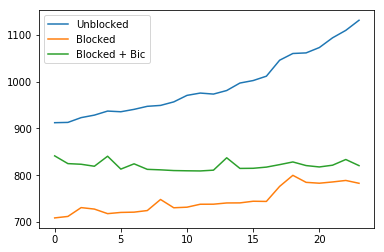

In [118]:
toplot="intensities vector bgsub"
conditioni=df["condition"].unique()
for condition in dfint["condition"].unique():
    
    df2plot=dfint[dfint["condition"]==condition]
    plt.plot(np.mean(df2plot[toplot].tolist(),axis=0))
    plt.legend(conditioni)

In [119]:
dfint.to_pickle(expdir+'longterm_intensitiespart2.pkl')

In [183]:
intensities_concat={"namestem":[],
            "condition":[],
            "intensities vector":[],
            "intensities vector bgsub":[]}
for i in range(0,len(dfintearly)):
    stemearly=dfintearly["namestem"][i].split('\\')[-1]
    intensities_concat["namestem"].append(stemearly)
    
    intensities_concat["condition"].append(dfintearly[dfintearly["namestem"].str.contains(stemearly)]["condition"].values[0])
    
    a=dfintearly[dfintearly["namestem"].str.contains(stemearly)]["intensities vector"].values[0]
    b=dfint[dfint["namestem"].str.contains(stemearly)]["intensities vector"].values[0]
    intensities_concat["intensities vector"].append(a+b)
    
    a=dfintearly[dfintearly["namestem"].str.contains(stemearly)]["intensities vector bgsub"].values[0]
    b=dfint[dfint["namestem"].str.contains(stemearly)]["intensities vector bgsub"].values[0]
    intensities_concat["intensities vector bgsub"].append(a+b)

In [184]:
dfincon=pd.DataFrame(intensities_concat)

In [185]:
dfincon["condition"].unique()

array(['Unblocked', 'Blocked', 'Blocked + Bic'], dtype=object)

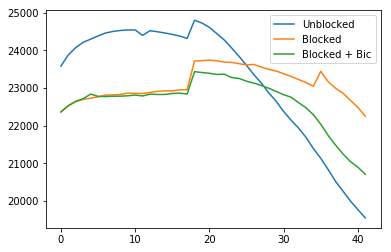

In [189]:
toplot="intensities vector"
conditioni=dfincon["condition"].unique()
for condition in dfincon["condition"].unique():
    
    df2plot=dfincon[dfincon["condition"]==condition]
    plt.plot(np.mean(df2plot[toplot].tolist(),axis=0))
    plt.legend(conditioni)

In [162]:
dfincon["condition"].unique()

array(['Unblocked'], dtype=object)

In [190]:
dfincon.to_pickle(expdir+'longterm_intensities_twofoldersconcatenated.pkl')